# Exploratory Data Analysis

## Hardcoded Variables

In [119]:
weathercan_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/TM_PHES/weathercan_data.csv"
gauge_location_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/TM_PHES/gauge_data.csv"
elk_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Elk River -Fernie.csv"
hosmer_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Hosmer Creek - Diversions.csv"
michel_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Michel Creek -Corbin Creek.csv"
crowsnest_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Crowsnest River - Frank.csv"

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Utility Functions

In [3]:
def describe_dataframes_to_dataframe(dataframes_dict):
    """
    Takes a dictionary of DataFrames and creates a new DataFrame with the summary statistics
    from the .describe() method for each DataFrame.

    Parameters:
    - dataframes_dict: Dictionary where keys are DataFrame names and values are DataFrames.

    Returns:
    - summary_df: DataFrame containing summary statistics for each input DataFrame.
    """
    summary_data = {}
    
    for df_name, df in dataframes_dict.items():
        summary_data[df_name] = df.describe()
    
    summary_df = pd.concat(summary_data, axis=1).T
    return summary_df

In [4]:
def preprocess_weather_data(df):
    """
    Takes the weather canada data, drops unwanted columns and adds two new columns:
    'monthly_mean_precip': Averages the precipitation data over the month for each weather station
    'swe': Snow water equivalent calculated by SWE[cm] = snow density(-) * snow depth(cm)
           Snow density is assumed to be 0.1
    
    Parameters:
    - df: Weather Canada DataFrame

    Returns:
    - df: Weather Canada DataFrame with new columns and dropped columns
    """
    # Columns to drop
    columns_to_drop = ['station_operator', 'climate_id', 'WMO_id', 'TC_id']

    # Drop specified columns and columns containing the word 'flag'
    df.drop(columns=columns_to_drop + [col for col in df.columns if 'flag' in col.lower()], inplace=True)

    # Snow Density (assumed)
    snow_density = 0.1  # g/cm^3

    # Creating a new column for Snow Water Equivalent (SWE)
    df['swe'] = df['total_snow'] * snow_density

    # Creating a new column for mean monthly precip
    df['monthly_mean_precip'] = df.groupby(['station_name', 'year', 'month'])['total_precip'].transform('mean')
    
    return df

In [146]:

def create_new_dataframe(gauge_df):
    """
    Takes a gauge station dataframe, drops unwanted columns and adds two new columns:
    'Daily_Discharge_m3/s': Daily discharge value where PARAM = 1
    'Daily_Level_m': Daily water level where PARAM = 2
    
    Parameters:
    - gauge_df: Gauges Station DataFrame from original_dfs list in create_and_concat_dataframes()

    Returns:
    - new_df: gauge_df DataFrame with new columns and dropped columns
    """
    # Remove spaces from column names
    gauge_df.columns = gauge_df.columns.str.replace(' ', '')

    id_column_name = 'ID'

    # Create a mask for PARAM equal to 1
    param_1_mask = (gauge_df['PARAM'] == 1) & gauge_df['Value'].notna()

    # Create a mask for PARAM equal to 2
    param_2_mask = (gauge_df['PARAM'] == 2) & gauge_df['Value'].notna()

    # Create the new DataFrame using vectorized operations
    new_df = pd.DataFrame({
        'ID': gauge_df[id_column_name],
        'Date': gauge_df['Date'],
        'Value': gauge_df['Value'],
        'Daily_Discharge_m3/s': gauge_df['Value'].where(param_1_mask),
        'Daily_Level_m': gauge_df['Value'].where(param_2_mask)
    }).dropna(subset=['Value'])

    return new_df

In [154]:
def create_and_concat_dataframes(original_dfs, additional_df=None):
    """
    Takes the four gauge station data and uses the create_new_dataframe function to clean up. 
    Concatenates the dataframes and merges on with gauge station name and locations. 
    Parameters:
    - original_dfs: list of the gauge station DataFrames
    - additional_df: gauge station name and location DataFrame

    Returns:
    - concatenated_df: All interested gauge station data in one DataFrame
    """
    # Container for processed DataFrames
    processed_dfs = []

    for original_df in original_dfs:
        # Process each DataFrame using the create_new_dataframe function
        processed_df = create_new_dataframe(original_df)
        processed_dfs.append(processed_df)

    # Concatenate all processed DataFrames
    concatenated_df = pd.concat(processed_dfs, ignore_index=True)

    # If additional_df is provided, merge it with the concatenated_df
    if additional_df is not None:
        # Merge DataFrames on 'ID' column using 'outer' to keep all data from both DataFrames
        concatenated_df = pd.merge(concatenated_df, additional_df, on='ID', how='outer')
    
    # Convert 'Date' column to datetime
    concatenated_df['Date'] = concatenated_df['Date'].str.replace('/', '-')
    concatenated_df['Date'] = pd.to_datetime(concatenated_df['Date'])

    return concatenated_df

## Data Engineering

### Weather

elev(m) \
temp(°C) \
precip(cm)

In [ ]:
# TODO:
# crosscorrelation


In [5]:
weathercan_df = pd.read_csv(weathercan_path)
weathercan_df = preprocess_weather_data(weathercan_df)
weathercan_df.head(1)

C:\Users\14037\AppData\Local\Temp\ipykernel_9540\3508997774.py:1: DtypeWarning: Columns (7,9,14,16,18,20,22,24,26,28,30,32,34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  weathercan_df = pd.read_csv(weathercan_path)


,station_name,station_id,prov,lat,lon,elev,date,year,month,day,...,max_temp,mean_temp,min_temp,snow_grnd,spd_max_gust,total_precip,total_rain,total_snow,swe,monthly_mean_precip
0,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-01,1998,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Group by 'station_name'
grouped_df = weathercan_df.groupby('station_name')

# Create a dictionary to store DataFrames
station_dfs = {}

# Iterate through groups and create DataFrames
for station_name, station_group in grouped_df:
    # Name each DataFrame based on station_name
    df_name = station_name.replace(' ', '_') + '_df'
    # Add the DataFrame to the dictionary
    station_dfs[df_name] = station_group.copy()

# Get the list of all new station DataFrame names
new_station_df_names = list(station_dfs.keys())
new_station_df_names

['BLAIRMORE_HQTS_RS_df',
 'COLEMAN_df',
 'COLEMAN_RS_df',
 'CORBIN_df',
 'CROWSNEST_df',
 'CROWSNEST_CREEK_df',
 'IRONSTONE_LO_df',
 'NATAL_df',
 'NATAL_HARMER_RIDGE_df',
 'NATAL_KAISER_RESOURCES_df',
 'PELLETIER_CREEK_df',
 'SPARWOOD_df',
 'SPARWOOD_CS_df',
 'WILLOUGHBY_RIDGE_df']

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

summary_df = describe_dataframes_to_dataframe(station_dfs)
#summary_df

In [8]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

### Hydrometric

Daily Discharge (m&sup3;/s)\
Daily Water Level (m)

In [120]:
gauge_location_df = pd.read_csv(gauge_location_path)
elk_df = pd.read_csv(elk_path, header=1)
hosmer_df = pd.read_csv(hosmer_path, header=1)
michel_df = pd.read_csv(michel_path, header=1)
crowsnest_df = pd.read_csv(crowsnest_path, header=1)

In [121]:
gauge_location_df.head(3)

,Station_name,ID,Years,lat,lon,gross_drainage_area_km2,lat_dd,lon_dd
0,ELK RIVER AT FERNIE,08NK002,1925-2022,"49°30'12"" N","115°04'12"" W",3090.0,49.503333,-115.070000
1,HOSMER CREEK ABOVE DIVERSIONS,08NK026,1981-2021,"49°35'06"" N","114°57'24"" W",6.4,49.585000,-114.956667
2,MICHEL CREEK ABOVE CORBIN CREEK,08NK028,1984-1995,"49°30'44"" N","114°40'33"" W",35.9,49.512222,-114.675833


In [142]:
elk_df.head(2)

,ID,PARAM,Date,Value,SYM
0,08NK002,1,1925/05/22,205.0,NaN
1,08NK002,1,1925/05/23,200.0,NaN


In [106]:
filtered_rows1 = crowsnest_df.query("PARAM == 2")
filtered_rows1.count()

 ID      4018
PARAM    4018
Date     4018
Value    3978
SYM        13
dtype: int64

In [155]:
original_dfs = [elk_df, hosmer_df, michel_df, crowsnest_df]

# Call the function to create, concatenate, and merge DataFrames
hydrometric_df = create_and_concat_dataframes(original_dfs, gauge_location_df)
hydrometric_df.head(3)

,ID,Date,Value,Daily_Discharge_m3/s,Daily_Level_m,Station_name,Years,lat,lon,gross_drainage_area_km2,lat_dd,lon_dd
0,08NK002,1925-05-22,205.0,205.0,NaN,ELK RIVER AT FERNIE,1925-2022,"49°30'12"" N","115°04'12"" W",3090.0,49.503333,-115.07
1,08NK002,1925-05-23,200.0,200.0,NaN,ELK RIVER AT FERNIE,1925-2022,"49°30'12"" N","115°04'12"" W",3090.0,49.503333,-115.07
2,08NK002,1925-05-24,192.0,192.0,NaN,ELK RIVER AT FERNIE,1925-2022,"49°30'12"" N","115°04'12"" W",3090.0,49.503333,-115.07


In [156]:
hydrometric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77310 entries, 0 to 77309
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       77310 non-null  object        
 1   Date                     77310 non-null  datetime64[ns]
 2   Value                    77310 non-null  float64       
 3   Daily_Discharge_m3/s     65541 non-null  float64       
 4   Daily_Level_m            11769 non-null  float64       
 5   Station_name             77310 non-null  object        
 6   Years                    77310 non-null  object        
 7   lat                      77310 non-null  object        
 8   lon                      77310 non-null  object        
 9   gross_drainage_area_km2  77310 non-null  float64       
 10  lat_dd                   77310 non-null  float64       
 11  lon_dd                   77310 non-null  float64       
dtypes: datetime64[ns](1), float64(6)

## Plots & Analysis

In [9]:
# TODO:
# Hydrometric

### Weather Station Visuals

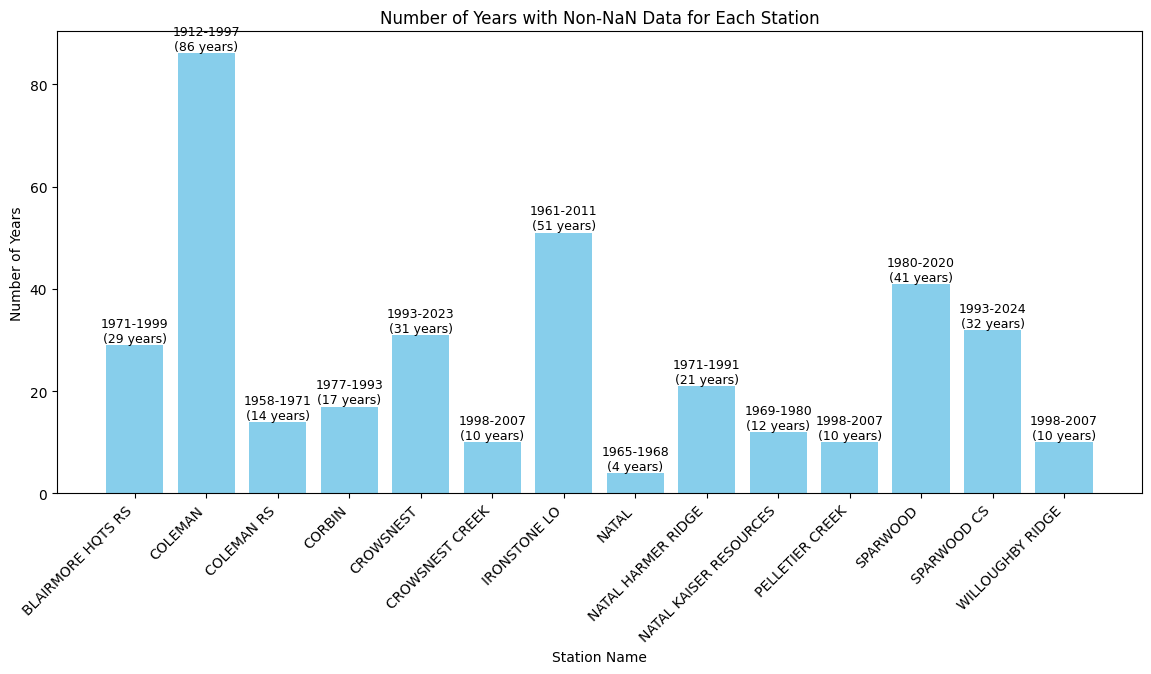

In [10]:
# Group by 'station_name' and get the range of years for each station
station_years_range = (
    weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
    .groupby('station_name')['year']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# Plotting the histogram with the correct year range and station names
plt.figure(figsize=(14, 6))

# Plotting the bar chart
bar_plot = plt.bar(station_years_range.index, station_years_range['count'], color='skyblue')

# Adding text on top of each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
    end_year = min(max_year, weathercan_df['year'].max())  # Set the maximum year to the overall max year
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{min_year}-{end_year}\n({count} years)",
             ha='center', va='bottom', fontsize=9, color='black')

plt.title('Number of Years with Non-NaN Data for Each Station')
plt.xlabel('Station Name')
plt.ylabel('Number of Years')
plt.xticks(rotation=45, ha='right')
plt.show()

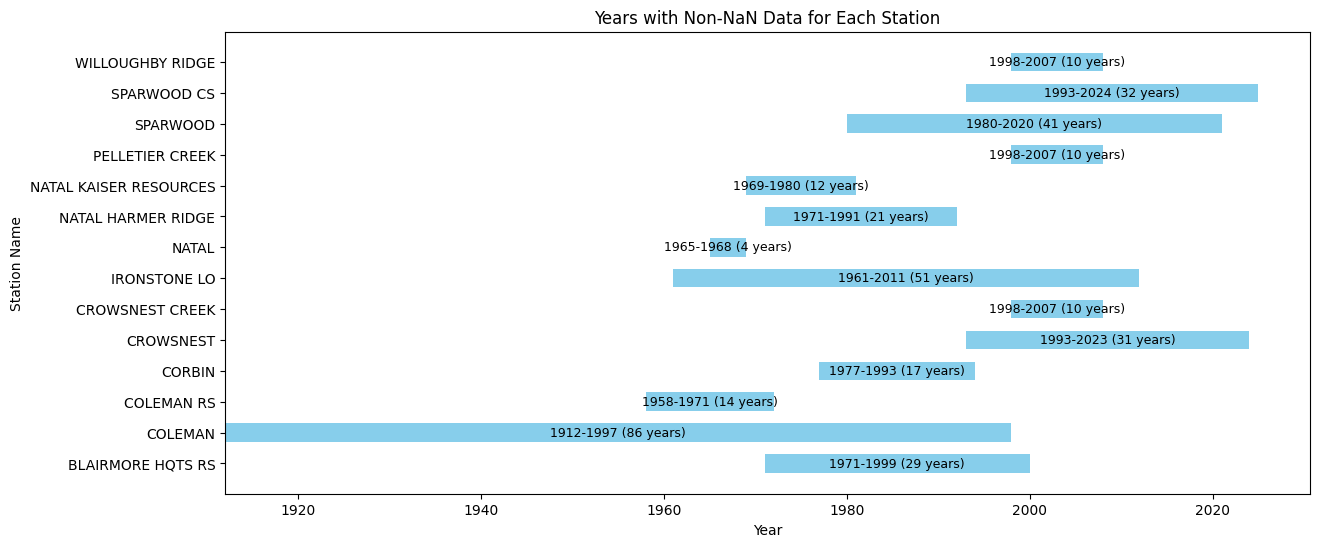

In [11]:

# Group by 'station_name' and get the range of years for each station
station_years_range = (
    weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
    .groupby('station_name')['year']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# Plotting the horizontal bar chart
plt.figure(figsize=(14, 6))
bar_plot = plt.barh(station_years_range.index, station_years_range['count'], 
                   left=station_years_range['min'], color='skyblue', height=0.6)

# Adding concise text beside each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{min_year}-{max_year} ({count} years)", ha='center', va='center', fontsize=9, color='black')

plt.title('Years with Non-NaN Data for Each Station')
plt.xlabel('Year')
plt.ylabel('Station Name')
plt.show()


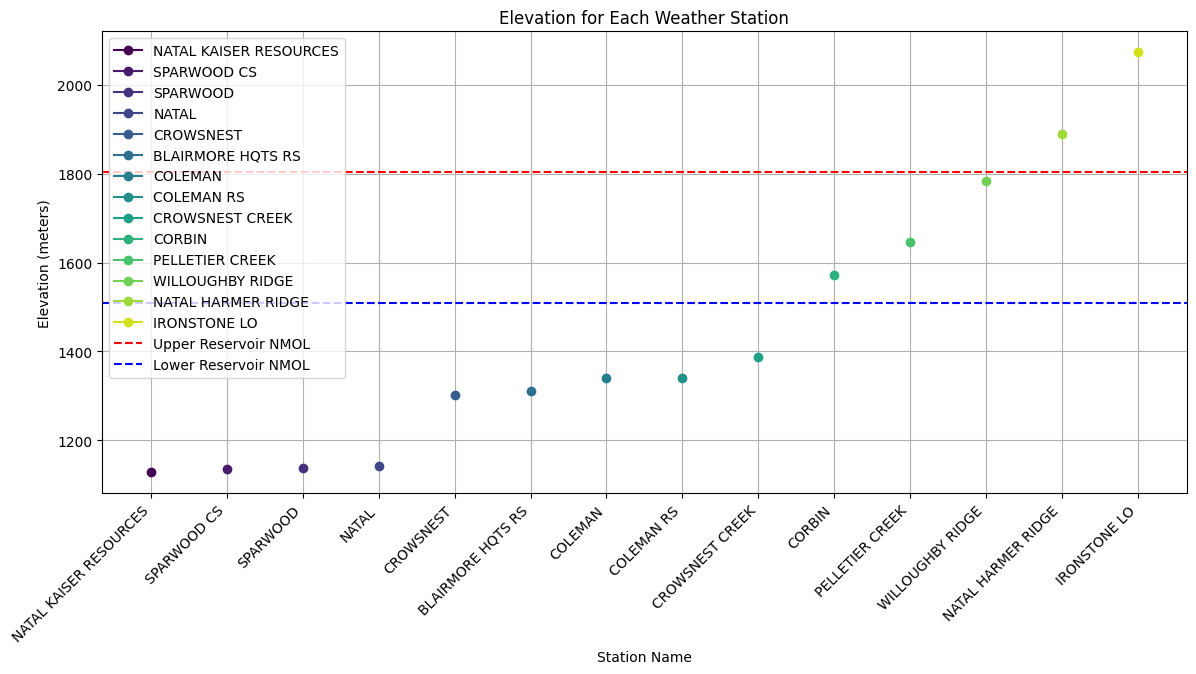

In [12]:
# Group by 'station_name' and get the mean elevation for each station
station_elevation = weathercan_df.groupby('station_name')['elev'].mean().reset_index()

# Sorting the data by elevation for better visualization
station_elevation = station_elevation.sort_values(by='elev')

# Elevation values for Upper and Lower Reservoir NMOL
upper_reservoir_elevation = 1803.3
lower_reservoir_elevation = 1509

# Plotting the line chart for station elevations with labels and different colors
plt.figure(figsize=(14, 6))
for i, (station, elevation) in enumerate(zip(station_elevation['station_name'], station_elevation['elev'])):
    plt.plot([i], [elevation], marker='o', linestyle='-', label=station, color=plt.cm.viridis(i / len(station_elevation)))

# Adding horizontal lines for Upper and Lower Reservoir NMOL elevations
plt.axhline(y=upper_reservoir_elevation, color='red', linestyle='--', label='Upper Reservoir NMOL')
plt.axhline(y=lower_reservoir_elevation, color='blue', linestyle='--', label='Lower Reservoir NMOL')

plt.title('Elevation for Each Weather Station')
plt.xlabel('Station Name')
plt.ylabel('Elevation (meters)')
plt.xticks(range(len(station_elevation)), station_elevation['station_name'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

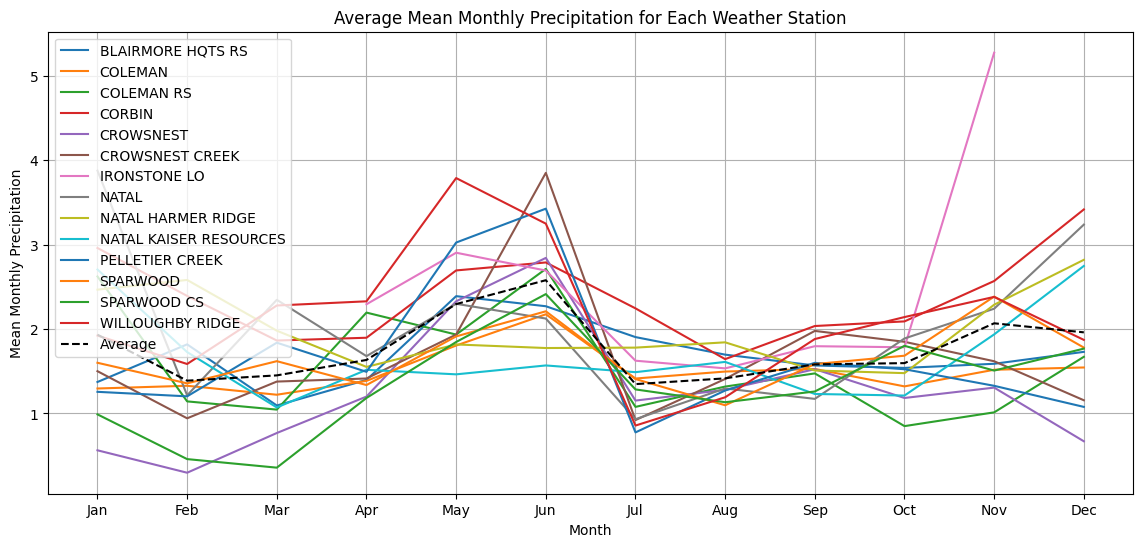

In [13]:
# Group by 'station_name', 'year', and 'month' and calculate the mean precipitation
mean_monthly_precip = (
    weathercan_df.groupby(['station_name', 'month'])['total_precip']
    .mean()
    .reset_index()
)

# Group by 'month' and calculate the average mean monthly precipitation for each station
average_monthly_precip = mean_monthly_precip.groupby('month')['total_precip'].mean().reset_index()

# Pivot the table to have each station as a line on the plot
station_monthly_precip = mean_monthly_precip.pivot(index='month', columns='station_name', values='total_precip')

# Plotting the line chart for average mean monthly precipitation for each station
plt.figure(figsize=(14, 6))
for station in station_monthly_precip.columns:
    plt.plot(station_monthly_precip.index, station_monthly_precip[station], label=station)

# Plotting the average mean monthly precipitation line
plt.plot(average_monthly_precip['month'], average_monthly_precip['total_precip'], linestyle='--', color='black', label='Average')

plt.title('Average Mean Monthly Precipitation for Each Weather Station')
plt.xlabel('Month')
plt.ylabel('Mean Monthly Precipitation')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

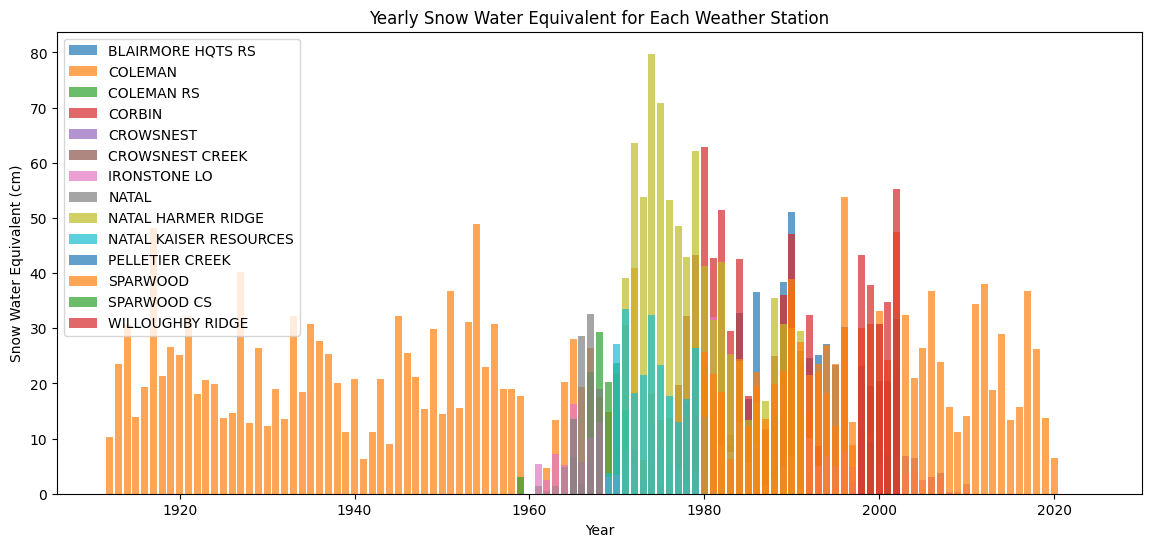

In [14]:
# Group by 'station_name' and 'year', then calculate the sum of snow water equivalent for each year and station
yearly_swe = weathercan_df.groupby(['station_name', 'year'])['swe'].sum().reset_index()

# Plotting the bar chart
plt.figure(figsize=(14, 6))
for station in yearly_swe['station_name'].unique():
    station_data = yearly_swe[yearly_swe['station_name'] == station]
    plt.bar(station_data['year'], station_data['swe'], label=station, alpha=0.7)

plt.title('Yearly Snow Water Equivalent for Each Weather Station')
plt.xlabel('Year')
plt.ylabel('Snow Water Equivalent (cm)')
plt.legend()
plt.show()

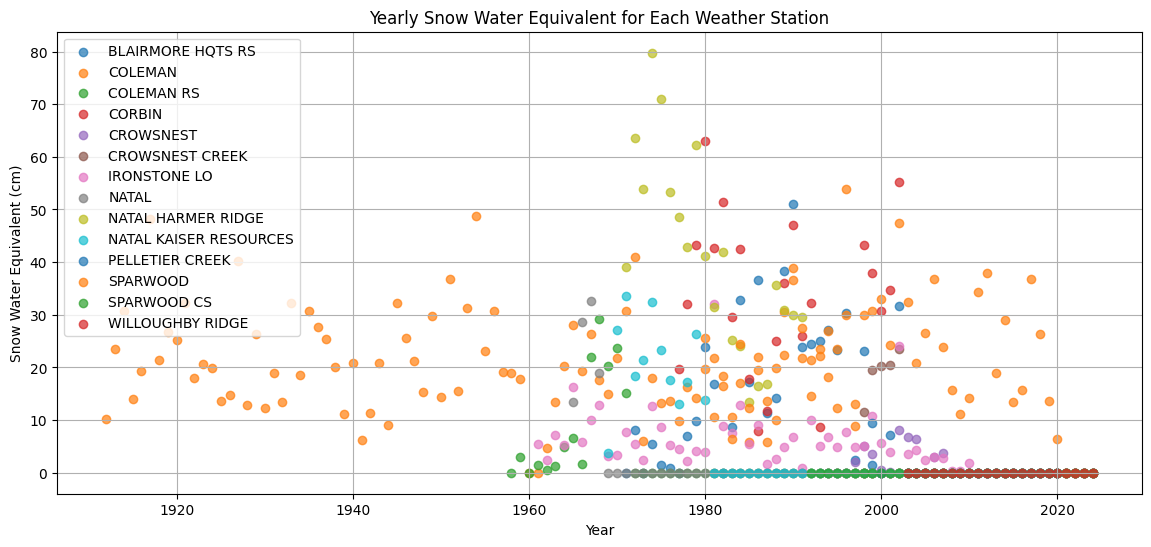

In [15]:
# Group by 'station_name' and 'year', then calculate the sum of snow water equivalent for each year and station
yearly_swe = weathercan_df.groupby(['station_name', 'year'])['swe'].sum().reset_index()

# Plotting the scatter plot
plt.figure(figsize=(14, 6))
for station in yearly_swe['station_name'].unique():
    station_data = yearly_swe[yearly_swe['station_name'] == station]
    plt.scatter(station_data['year'], station_data['swe'], label=station, alpha=0.7)

plt.title('Yearly Snow Water Equivalent for Each Weather Station')
plt.xlabel('Year')
plt.ylabel('Snow Water Equivalent (cm)')
plt.legend()
plt.grid(True)
plt.show()

### Gauge Station Visuals

In [ ]:
# plot flows over time for each gauge
# plot flows over time for each gauge (peak annual discharge vs drainage area)


In [ ]:

# # Group by 'station_name' and get the range of years for each station
# station_years_range = (
#     weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
#     .groupby('station_name')['year']
#     .agg(['min', 'max'])
# )

# # Calculate the number of years for each station
# station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# # Plotting the horizontal bar chart
# plt.figure(figsize=(14, 6))
# bar_plot = plt.barh(station_years_range.index, station_years_range['count'], 
#                    left=station_years_range['min'], color='skyblue', height=0.6)

# # Adding concise text beside each bar with the correct year range
# for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
#     plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
#              f"{min_year}-{max_year} ({count} years)", ha='center', va='center', fontsize=9, color='black')

# plt.title('Years with Non-NaN Data for Each Station')
# plt.xlabel('Year')
# plt.ylabel('Station Name')
# plt.show()


In [ ]:
# # Group by 'station_name' and get the mean elevation for each station
# station_elevation = weathercan_df.groupby('station_name')['elev'].mean().reset_index()

# # Sorting the data by elevation for better visualization
# station_elevation = station_elevation.sort_values(by='elev')

# # Elevation values for Upper and Lower Reservoir NMOL
# upper_reservoir_elevation = 1803.3
# lower_reservoir_elevation = 1509

# # Plotting the line chart for station elevations with labels and different colors
# plt.figure(figsize=(14, 6))
# for i, (station, elevation) in enumerate(zip(station_elevation['station_name'], station_elevation['elev'])):
#     plt.plot([i], [elevation], marker='o', linestyle='-', label=station, color=plt.cm.viridis(i / len(station_elevation)))

# # Adding horizontal lines for Upper and Lower Reservoir NMOL elevations
# plt.axhline(y=upper_reservoir_elevation, color='red', linestyle='--', label='Upper Reservoir NMOL')
# plt.axhline(y=lower_reservoir_elevation, color='blue', linestyle='--', label='Lower Reservoir NMOL')

# plt.title('Elevation for Each Weather Station')
# plt.xlabel('Station Name')
# plt.ylabel('Elevation (meters)')
# plt.xticks(range(len(station_elevation)), station_elevation['station_name'], rotation=45, ha='right')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# plot flows over time for each gauge
# plot flows over time for each gauge (peak annual discharge vs drainage area)


## Cross-Correlation 

In [ ]:
# cross correlation, take avg of each month for each variable ?
# correlate each station for each month

In [ ]:

# Choose three weather stations for correlation
station_names = ['Station1', 'Station2', 'Station3']

# Filter data for the selected stations
selected_data = weathercan_df[weathercan_df['station_name'].isin(station_names)].drop(['station_name', 'date'], axis=1)

# Calculate correlation matrix for the selected stations
correlation_matrix = selected_data.corr()

# Print or use the resulting correlation matrix as needed
print(f'Correlation Matrix between {", ".join(station_names)}:\n{correlation_matrix}\n')

In [ ]:
# assess multicollinearity
co_lin_df = train_raw.copy()
co_lin_df['constant'] = 1
print('Variance Inflation Factors')
print(calc_vif(co_lin_df))

print('')
print('Corelation Matrix')
rs = np.random.RandomState(0)
corr = train_raw.corr().abs().copy()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:

upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(bool))

upper_tri.style.background_gradient(cmap='coolwarm')

## Supporting 

In [36]:
weathercan_df.dtypes

station_name      object
station_id         int64
prov              object
lat              float64
lon              float64
elev             float64
date              object
year               int64
month              int64
day                int64
qual              object
cool_deg_days    float64
dir_max_gust     float64
heat_deg_days    float64
max_temp         float64
mean_temp        float64
min_temp         float64
snow_grnd        float64
spd_max_gust     float64
total_precip     float64
total_rain       float64
total_snow       float64
dtype: object

In [37]:
weathercan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252964 entries, 0 to 252963
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   station_name   252964 non-null  object 
 1   station_id     252964 non-null  int64  
 2   prov           252964 non-null  object 
 3   lat            252964 non-null  float64
 4   lon            252964 non-null  float64
 5   elev           252964 non-null  float64
 6   date           252964 non-null  object 
 7   year           252964 non-null  int64  
 8   month          252964 non-null  int64  
 9   day            252964 non-null  int64  
 10  qual           4376 non-null    object 
 11  cool_deg_days  87904 non-null   float64
 12  dir_max_gust   9675 non-null    float64
 13  heat_deg_days  87904 non-null   float64
 14  max_temp       88589 non-null   float64
 15  mean_temp      87904 non-null   float64
 16  min_temp       88441 non-null   float64
 17  snow_grnd      30206 non-null

In [49]:
CROWSNEST_CREEK_df = station_dfs['CROWSNEST_CREEK_df']

# Group by 'year' and 'month' and calculate the mean precipitation
CROWSNEST_CREEK_df['monthly_mean_precip'] = (
    CROWSNEST_CREEK_df.groupby(['year', 'month'])['total_precip']
    .transform('mean'))

CROWSNEST_CREEK_df

,station_name,station_id,prov,lat,lon,elev,date,year,month,day,...,heat_deg_days,max_temp,mean_temp,min_temp,snow_grnd,spd_max_gust,total_precip,total_rain,total_snow,monthly_mean_precip
0,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-01,1998,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-02,1998,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-03,1998,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-04,1998,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,1998-01-05,1998,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9500,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-05,2024,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9501,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-06,2024,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9502,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-07,2024,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9503,CROWSNEST CREEK,10690,AB,49.61,-114.68,1387.0,2024-01-08,2024,1,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
distinct_values_crowsnest_year = CROWSNEST_CREEK_df['year'].unique()
distinct_values_crowsnest_year

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024], dtype=int64)

In [52]:
distinct_values_crowsnest_year_counts = CROWSNEST_CREEK_df['year'].value_counts()
distinct_values_crowsnest_year_counts

year
2000    366
2004    366
2020    366
2008    366
2016    366
2012    366
1998    365
2014    365
2023    365
2022    365
2021    365
2019    365
2018    365
2017    365
2015    365
2011    365
2013    365
1999    365
2010    365
2009    365
2007    365
2006    365
2005    365
2003    365
2002    365
2001    365
2024      9
Name: count, dtype: int64

In [53]:
distinct_values_crowsnest = CROWSNEST_CREEK_df['monthly_mean_precip'].unique()
distinct_values_crowsnest

array([       nan, 0.67419355, 2.12333333, 2.1516129 , 1.13225806,
       1.04642857, 0.91290323, 1.24333333, 2.08064516, 3.10666667,
       1.21612903, 2.17741935, 0.92666667, 2.88709677, 2.65666667,
       0.55806452, 1.83548387, 0.91724138, 1.25483871, 0.88666667,
       2.26451613, 3.52666667, 0.77096774, 0.8516129 , 0.96774194,
       0.40645161, 0.93214286, 1.26129032, 2.28965517, 0.59677419,
       3.62      , 0.32258065, 0.15806452, 0.4       , 1.44193548,
       1.06      , 1.03225806, 2.4       , 2.05714286, 1.38709677,
       1.33      , 3.2483871 , 3.80666667, 0.56129032, 1.17741935,
       2.45333333, 0.74333333, 1.39677419, 1.32903226, 0.30357143,
       2.59032258, 2.39666667, 1.78064516, 1.82      , 0.12258065,
       0.11612903, 0.78      , 2.3483871 , 2.05333333, 0.11724138,
       1.0483871 , 0.78333333, 1.85483871, 3.24666667, 1.71935484,
       3.19354839, 2.18333333, 1.51612903, 1.14      , 1.2       ,
       2.01290323, 1.25      , 1.18709677, 0.99666667, 1.71612

In [56]:
# Check if monthly mean calc match
monthly_mean_precip_counts = (
    CROWSNEST_CREEK_df.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)
monthly_mean_precip_counts

,year,monthly_mean_precip,counts
0,1998,0.674194,31
1,1998,2.123333,30
2,1998,2.151613,31
3,1999,0.558065,31
4,1999,0.912903,31
...,...,...,...
78,2005,2.830769,30
79,2005,3.106452,31
80,2005,5.123333,30
81,2005,7.830000,30


In [65]:
# Check if monthly mean calc match
# Filter the DataFrame for the station 'CROWSNEST_CREEK'
CROWSNEST_CREEK_df_from_wc = weathercan_df[weathercan_df['station_name'] == 'CROWSNEST CREEK']

# Group by 'year' and 'monthly_mean_precip' and get value counts
monthly_mean_precip_counts_wc = (
    CROWSNEST_CREEK_df_from_wc.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)

# Print or use the resulting DataFrame as needed
monthly_mean_precip_counts_wc

,year,monthly_mean_precip,counts
0,1998,0.674194,31
1,1998,2.123333,30
2,1998,2.151613,31
3,1999,0.558065,31
4,1999,0.912903,31
...,...,...,...
78,2005,2.830769,30
79,2005,3.106452,31
80,2005,5.123333,30
81,2005,7.830000,30
